# Whisky Project

## 2. Data Exploration and Cleaning

In [2]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import re
import scipy
from fuzzywuzzy import process
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import wordnet, stopwords
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('words')
nltk.download('omw-1.4')
from sklearn.feature_extraction.text import CountVectorizer

df = pd.read_csv('./data/gathering_complete.csv', index_col = 'Unnamed: 0')
df.sample(3)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jamie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jamie\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\jamie\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\jamie\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


,timestamp,name,username,link,rating,region,price,date,review,reviewlength
20782,4/2/2017 15:48:30,Glenmorangie Lasanta,An_Imperfect_Guy,https://www.reddit.com/r/Scotch/comments/631zg...,80,Highlands,NaN,04/02/17,I'm back again with some reviews of my latest ...,2707
9132,10/17/2018 20:46:06,Bulleit Rye,strasse007,https://old.reddit.com/r/bourbon/comments/9p4t...,78,Rye,NaN,10/17/18,This was a mystery that I recently reviewed as...,2654
12849,2/23/2017 16:13:58,Croftengea 10 2006 Exclusive Malts,throwboats,https://www.reddit.com/r/Scotch/comments/5ry5m...,81,Highlands,NaN,02/04/17,Croftengea is apparently a peated single malt ...,1116


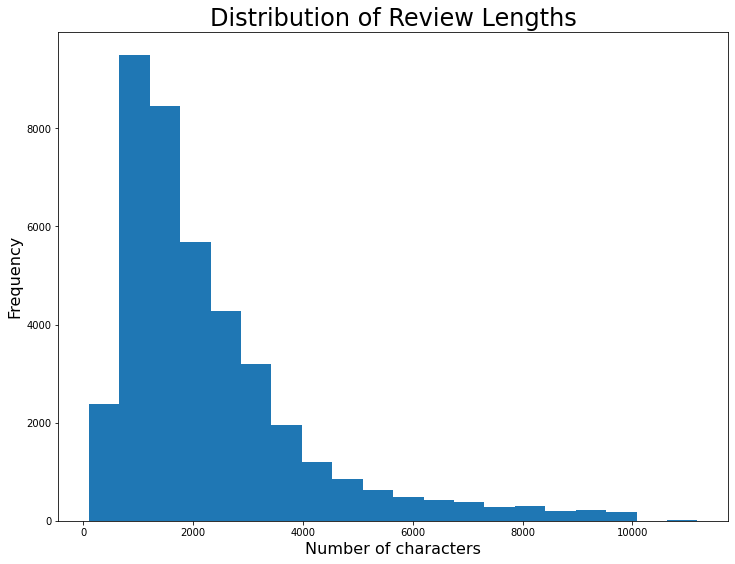

In [7]:
# Show histogram of reviewlengths

plt.figure(figsize=(12,9))
plt.hist(df['reviewlength'], bins=20)
plt.xlabel('Number of characters', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.title('Distribution of Review Lengths', fontsize=24);

I have the raw text extracted from the Reddit comments and submissions, and the task now is to extract separate strings for the 'nose', 'palate' and 'finish' (where they exist) for the particular whisky in the review. What follows initially here is my initial approach which I had to abandon, followed by a more fruitful path.

#### Extracting 'Nose', 'Palate' and Finish' - Initial Approach

These are the regex expressions I'll need to extract out the tasting notes for nose, palate/taste, and finish respectively. 

    r"(?:[Nn]ose)[^\n]+"
    r"(?:[Pp]alate)[^\n]+|(?:[Tt]aste)[^\n]+"
    r"(?:[Ff]inish)[^\n]+"
    
The plan is to create a whisky by adjective matrix (i.e. a CountVectoriser object) that looks something like this:

|   | Nose_vanilla  | Nose_honey  | ...  | Palate_woody  | Palate_cherry  | ...  | Finish_dry | ... |
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
| Aberlour   | 1  | 0  | ...  | 0  | 1  | ...  | 0  | ... |
| Glenlivet  |  0 |  1 | .. |  0 | 0  | ... | 0  | ...| 
| Glenfarclas  | 0  | 0  | ...  | 0  | 1  | ...  | 1  | ...|
| Macallan  | 1  | 0  | ...  | 0  | 0  | ...  | 0  |...|
| ...  | ...   | ...  | ...  | ...  | ...  | ...  | ...  |...|

I'll try disambiguating the nose, palate and finish first of all, and then try it where it's all lumped together. 

In [2]:
# Testing out regex - extracting palate 
i = np.random.randint(0,40000)
text = df.iloc[i,:]['review']
extracted = re.findall(r"(?:[Pp]alate)[^\n]+|(?:[Tt]aste)[^\n]+", text)
print(text)
print('\n\n\n\n\n extracted text for the palate/taste is \n\n\n\n\n', extracted)

**Whisky Network Reviews #98-100**

To celebrate my 100th whisky network review here, I thought I would report on the vilest whisky that I have ever tried. :)

But first a little background – on a recent trip to Zurich, I managed to try a number of Swiss single malts. Appenzeller Säntis Malt ("Swiss Alpine Whisky") is an offshoot of a brewery (Brauerei Locher).  A signature feature is their use of old beer barrels for aging. Santis has been distilling since 1999 (when production first became legal in Switzerland), and they are currently one of the largest malt whisky producers there. 

Three of their current bottlings were available there as 50 mL sample bottles (ranging from ~$8-11 CAD each).  Let's see what they are like.

------------

**Santis Edition Sigel**

Edition Sigel is one of the base expressions available from this distiller. It is exclusively "matured in small oak beer casks" (with no finishing) and is bottled at 40% ABV. 

**Colour**: Light gold, but with a slightly brow

In [3]:
def extract_nose(text):
    try:
        extract_text = re.findall(r"(?:[Nn]ose)[^\n]+", text)
        extract_text = [extract_text[i].replace("*", "") 
         for i in range(len(extract_text))]
    except:
        extract_text = []
    return extract_text

def extract_palate(text):
    try:
        extract_text = re.findall(r"(?:[Pp]alate)[^\n]+|(?:[Tt]aste)[^\n]+", text)
        extract_text = [extract_text[i].replace("*", "") 
         for i in range(len(extract_text))]
    except:
        extract_text = []
    return extract_text

def extract_finish(text):
    try:
        extract_text = re.findall(r"(?:[Ff]inish)[^\n]+", text)
        extract_text = [extract_text[i].replace("*", "") 
         for i in range(len(extract_text))]
    except:
        extract_text = []
    return extract_text

df['nose']=df['review'].apply(extract_nose)
df['palate']=df['review'].apply(extract_palate)
df['finish']=df['review'].apply(extract_finish)
df.sample(3)

,timestamp,name,username,link,rating,region,price,date,review,reviewlength,nose,palate,finish
17310,10/27/2017 8:09:16,Glencadam 15,MajorHop,https://www.reddit.com/r/Scotch/comments/79342...,76,Highlands,NaN,10/27/17,**Distilled/Owned by:** Glencadam / Angus Dund...,696,"[Nose: Honey, fresh cut flowers, heather, and ...","[Palate/Taste: Vanilla, honey, barley malt, ap...","[Finish: Medium length and warmth. Ginger, nut..."
31432,8/10/2014 18:37:48,Mortlach 21 1990 Signatory Cask 7708,Scotch_Fanatic,http://www.reddit.com/r/Scotch/comments/2cx8sx...,91,Speyside,NaN,8/7/2014,Hello scotchit! Today i'm reviewing Signatory ...,775,"[Nose Juicy black berry, stewed dark fruits, r...","[Palate Sweet juicy black berry, spicy wood, i...",[Finish Tart pineapple and mandarin fades into...
20253,2/1/2013 13:19:08,Glenmorangie 10 Original,CodaRaven,http://www.reddit.com/r/Scotch/comments/17nlef...,72,Highlands,39,1/31/2013,* **Original**\n\ncolor: pale gold\n\nnose: fl...,3219,"[nose: flowery perfume, vanilla, pear apple, n...","[taste: light caramel, plain white rice, mild ...","[finish: simple, warm, a hint of something - ..."


We noticed before that we had reviews that concerned several bottles of whisky at once, and now we're in a position to identify these reviews by counting the size of the lists we've just produced for nose, palate and finish. The modal case should be that every row has one of each, but there's bound to be some discrepancies, and that's what I'll now investigate...

In [4]:
df['noselength']=df['nose'].apply(lambda x: len(x))
df['palatelength']=df['palate'].apply(lambda x: len(x))
df['finishlength']=df['finish'].apply(lambda x: len(x))

In [5]:
# more_than_2 is a list of the indices of rows that have 'nose', 'palate/taste', and 'finish'
# all at least 2 times, indicating more than one review taking place in all likelihood.
# exactly_one shows how many have one extracted bit for nose, palate and finish.

more_than_2 = df[(df['noselength']>=2) & (df['palatelength']>=2) & (df['finishlength']>=2)].index.tolist()
exactly_one = df[(df['noselength']==1) & (df['palatelength']==1) & (df['finishlength']==1)].index.tolist()

len(more_than_2), len(exactly_one)

(14393, 9097)

As you can see, we have a lot of multiple reviews and not many where things are unproblematically one item for nose, taste, and finish. And really I should have realised this earlier, because...

In [6]:
# duplicated is a list of all rows that have a link shared with another row

duplicate_links_list = df[df['link'].duplicated()]['link'].tolist()
duplicated = df[df['link'].isin(duplicate_links_list)].index.tolist()
len(duplicated)

10168

In [7]:
# The set of rows that are in both dataframes
both = set(more_than_2) & set(duplicated)

# The set of rows that are in more_than_2 but not in duplicated:
more_only = set(more_than_2) - set(duplicated)

# The set of rows that are in duplicated but not in more_than_2:
duplicated_only = set(duplicated) - set(more_than_2)

# Check - should add up to 10168+14393 = 24561 (it does)
# len(more_only) + len(duplicated_only) + 2*len(both)

len(both), len(more_only), len(duplicated_only)

(8798, 5595, 1370)

The good news here is that in the 'both' cases, we have 8798 rows where we have different whisky all with the same review text. What needs to happen here is merely that we need to split the text up and match each one with the correct whisky. I say 'merely' - that's probably not going to be that easy.

But this means that I have some other cases - the 5595 'more_only' cases. This is where there are two references to taste, nose and finish in the text, but only one whisky. What is happening here is usually that the author has compiled different notes under drinking the whisky neat and drinking it with water. Since they're all valid tasting notes (adding water usually just helps to 'open up' the whisky), the solution here is to simply combine the notes.

Finally, I have 1370 cases where there's duplicate reviews, but I haven't picked up on it by looking for 'nose', 'taste' and 'finish'. That's probably just that the review hasn't specifically broken out their review into nose, taste and finish, a problem that is affecting about 1/3 of my dataset. My plan at the moment is that, once I have compiled a matrix of all the adjectives I need, it will be a lot easier to go back into the reviews and simply search for those adjectives directly. It won't be as fine-grained as splitting them up into nose, taste, and finish, and it introduces more noise, so it may not be worth doing, but it's a possibility.

In [8]:
# Create copy of df to manipulate for the 8798 group
df_both = df.loc[list(both), :].copy()

# Sort by link
df_both = df_both.sort_values('link')

In [9]:
# creating a text file so I can browse through and see if I can figure out a way to 
# match the reviews

def printfile(df, name):
    '''
    INPUTS:
    df - pandas dataframe you want to print out
    name - name you want to give the text file
    OUTPUTS:
    -
    '''
    with open('./data/' + name, 'w') as file:
        for i in range((df.shape[0])):
            try:
                file.writelines('\n\n\n\n\n\n\n\n\n\nIndex is ' + str(df.index[i]) + '\n')
                file.writelines('Name is ' + str(df.iloc[i,1]) + '\n')
                file.writelines('Review is ' + str(df.iloc[i,8]) + '\n')
            except:
                continue
                
printfile(df_both, 'both.txt')

Looking through the text file I've just created, it seems as though a good way to split up the reviews that will work for something like 80% of them is by splitting up the review whenever it encounters the '/10(0)' token. This always comes at the end of the review of the particular whisky. The only problem then is that I'll need to match the whisky to the review. This is not so simple, because the name in the 'name' column won't necessarily match exactly. Thus, I'll have to use a bit of 'fuzzy string matching' (using a module called 'fuzzywuzzy') so I'll be able to pick out the review that's most likely to correspond to the correct one.

In [10]:
# Splitting review into a list with various things as separators
df_both['review'] = df_both['review'].str.split(r'/100|--|\*\*\*|___|&nbsp')

# Deleting small 'reviews' so that it doesn't confuse get_best_fit:
def del_small_reviews(reviewlist):
    '''
    INPUTS:
    reviewlist (list) - list of reviews
    OUTPUTS:
    newlist - reviews with the <100 character ones removed
    '''
    newlist=[]
    for review in reviewlist:
        if len(review)>50:
            newlist.append(review)
    return newlist

df_both['review'] = df_both['review'].apply(del_small_reviews)

In [11]:
def get_best_fit(name, reviewlist):
    '''
    INPUTS:
    name (string) - name of the whisky you're trying to identify the review for
    reviewlist (list) - list of potential reviews you're matching it to
    
    OUTPUTS:
    output (string) - best guess as to the review for that whisky
    '''
    bolded_name = r"\*\*" + re.escape(name) + r"\*\*" 
    bolded_match_list = []
    unbolded_match_list = []

    # Search for exact match on both unbolded and bolded name:
    for review in reviewlist:
        if re.search(bolded_name, review):
            bolded_match_list.append(review)
        if re.search(name, review):
            unbolded_match_list.append(review)

    # If there's only one exact match for bolded name, that's the review you want
    if len(bolded_match_list)==1:
        output = str(bolded_match_list[0])

    # If there's more than one exact match, use fuzzywuzzy to get best match from the matches
    elif len(bolded_match_list)>1:
        output = str(process.extractOne(name, bolded_match_list)[0])

    # If there's no exact matches...
    else:
        # If there's only one exact match for unbolded name, that's the review you want
        if len(unbolded_match_list)==1:
            output = str(unbolded_match_list[0])

        # If there's more than one exact match, use fuzzywuzzy to get best match from the matches
        elif len(unbolded_match_list)>1:
            output = str(process.extractOne(name, unbolded_match_list)[0])

        # If there's no matches on unbolded names either, just use fuzzywuzzy on original list:
        else:
            try:
                output = str(process.extractOne(name, reviewlist)[0])
            except:
                output = reviewlist
    return output

In [12]:
# Seems to work. Run on the whole thing 
df_both['review'] = df_both.apply(lambda x: get_best_fit(x['name'], x['review']), axis=1)

# Print out text file
printfile(df_both, 'both2.txt')

In [13]:
# Extract nose, palate and finish from the updated review
df_both['nose']=df_both['review'].apply(extract_nose)
df_both['palate']=df_both['review'].apply(extract_palate)
df_both['finish']=df_both['review'].apply(extract_finish)

In [14]:
# Re-do finding number of instances of 'nose', 'taste'/'palate', and 'finish' in the review
df_both['noselength']=df_both['nose'].apply(lambda x: len(x))
df_both['palatelength']=df_both['palate'].apply(lambda x: len(x))
df_both['finishlength']=df_both['finish'].apply(lambda x: len(x))

# Get counts
(df_both['noselength'].value_counts(), 
df_both['palatelength'].value_counts(), 
 df_both['finishlength'].value_counts())

(1     3483
 0     2514
 2     1539
 3      569
 4      305
 5      153
 6       84
 10      43
 8       41
 7       38
 12      14
 9       10
 11       5
 Name: noselength, dtype: int64,
 1     3148
 0     2327
 2     1697
 3      639
 4      391
 6      163
 5      151
 7       72
 8       55
 9       54
 10      45
 12      21
 11      18
 16      10
 23       7
 Name: palatelength, dtype: int64,
 1     3234
 0     2495
 2     1635
 3      686
 4      292
 5      159
 6      103
 7       70
 8       37
 11      30
 12      25
 9       17
 10      10
 13       5
 Name: finishlength, dtype: int64)

In [15]:
# List of problems still:
df_both_prob = df_both[(df_both['noselength']>1) & (df_both['palatelength']>1) & (df_both['finishlength']>1)].index.tolist()
df_zeroes = df_both[(df_both['noselength']==0) & (df_both['palatelength']==0) & (df_both['finishlength']==0)].index.tolist()
                                                  
# As a dataframe
df_probs = df_both.loc[df_both_prob,:].sort_values('link')
df_zeroes = df_both.loc[df_zeroes,:].sort_values('link')

# Print the reviews
printfile(df_probs, 'probs.txt')
printfile(df_zeroes, 'zeroes.txt')

In [16]:
len(df_probs['link'].unique()), len(df_zeroes['link'].unique())

(863, 968)

As you can see, there's still lots of problems, but there's just no easy way of cutting up multiple reviews and then identifying the correct one. I'll just have to take the ones that give me exactly one match for nose, taste, and finish, and leave the others, I think. Otherwise, I will have to spend literal weeks trying to get these reviews into the right shape, and that simply isn't a good use of time.




--------------

#### Extracting 'Nose', 'Palate' and Finish' - Subsequent Approach

A different approach was needed at this point. What I decided to do was create functions that automate the process of applying different rules to the rows in the 'review' column to separate them into a list of strings that might correspond to individual whiskies, and then progressively take off the rows where I'm relatively confident I've got the right one. 

So, first of all I need a function that splits the data frame into two, keeping rows that have nose, palate, finish = 1. The idea is that I'm going to progressively strengthen the rules on splitting up the 'review' column until I get as many hits as I can.

Note that I've also got a small helper function storage_rule_default() that defines the rule I'm using to decide whether to add a row to my store of successful hits (dfstore). I'll talk more about that in a second.

In [17]:
# create dfstore - dataframe that will store rows that have 1 string for 'nose', 'palate', and 
# for 'finish'
dfstore = df[(df['noselength']==1) & (df['palatelength']==1) & (df['finishlength']==1)].copy()

# default logical rule for what gets stored in dfstore
def storage_rule_default(df):
    return df[(df['noselength']==1) & (df['palatelength']==1) & (df['finishlength']==1)]

def filter_off_singular_reviews(dfnew, storage_rule=storage_rule_default, dfstore=dfstore):
    '''
    INPUTS:
    dfnew - pandas dataframe containing potential new rows to add to the store of good reviews.
    storage_rule - name of function that slices dataframe to get rows that should get stored.
    dfstore - dataframe store of singular reviews (i.e. where nose, palate and finish are all 
            just lists of length one)
    OUTPUTS:
    dfstore - same as above
    remain_idx - indices of the remaining rows
    '''
    # Make copy of dataframe
    df = dfnew.copy()
    
    # Extract nose, palate and finish from the dataframe
    df['nose']=df['review'].apply(extract_nose)
    df['palate']=df['review'].apply(extract_palate)
    df['finish']=df['review'].apply(extract_finish)
    
    # Finding number of instances of 'nose', 'taste'/'palate', and 'finish' in the review
    df['noselength']=df['nose'].apply(lambda x: len(x))
    df['palatelength']=df['palate'].apply(lambda x: len(x))
    df['finishlength']=df['finish'].apply(lambda x: len(x))

    # Update dfstore and dfremain
    dfadd = storage_rule(df)
    remain_idx = list(set(df.index) - set(dfadd.index))
    dfadd = dfadd.loc[list(set(dfadd.index)-set(dfstore.index)),:]
    dfstore = pd.concat([dfstore, dfadd], axis=0)

    return remain_idx, dfstore

# Run df through - dfstore should remain unchanged here
remain_idx, dfstore = filter_off_singular_reviews(df)
len(remain_idx), dfstore.shape

(31487, (9097, 16))

Now I need a function that applies in turn the different values I might use to separate out the 'review' text into a list, and then sends the results to get filtered off. 

In [18]:
rules_list = [
    r'___',
    r'--',
    r'##',
    r'~~~',
    r'\*\*\*',
    r'&nbsp;',
    r'/100',
    r'/10',
    r'Rating',
    r'Score',
    r'Overall',
    r'Total',
    r'Review',
    r'Conclusion',
]

def get_singular_reviews(rules_list, storage_rule=storage_rule_default, 
                         remain_idx=remain_idx, dfstore=dfstore):
    '''
    INPUTS:
    rules_list - list of the expressions to be fed into str.split to split up the 
    'review' column and then match the right review. 
    storage_rule - name of function that slices dataframe to get rows that should get stored.
    dfstore - dataframe of rows where we're pretty confident we've got the right tasting notes.
    remain_idx - indices of the rows from the original df not used.
    OUTPUTS:
    dfstore - dataframe of rows where we're pretty confident we've got the right tasting notes.
    remain_idx - indices of the rows from the original df not used.
    '''
    
    # Apply the rule for splitting the review up
    for rule in rules_list:
        # Keep track of size of dfstore
        numrows_old = dfstore.shape[0]

        # Create a df, dfremain to manipulate 
        dfremain = df.loc[remain_idx,:].copy()

        # Applying the rule to split the review
        print('Applying the rule {} ...'.format(rule))
        dfremain['review'] = dfremain['review'].str.split(rule)

        # Delete the small items in the list of 'reviews' so that it doesn't confuse get_best_fit:
        dfremain['review'] = dfremain['review'].apply(del_small_reviews)

        # Apply get_best_fit to the list of 'reviews' and extract 'nose', etc.
        dfremain['review'] = dfremain.apply(lambda x: get_best_fit(x['name'], x['review']), axis=1)

        # Drop any rows with null entries for 'nose', etc.
        dfremain[['nose', 'palate', 'finish']] = dfremain[['nose', 'palate', 'finish']].dropna()

        # Filter off rows with singular reviews for nose, etc.
        remain_idx, dfstore = filter_off_singular_reviews(dfremain, storage_rule, dfstore)
        print("{} rows added.".format(dfstore.shape[0]-numrows_old))
        
    return remain_idx, dfstore

# Commented out because time-consuming and results are eventually stored and reloaded anyway.

#remain_idx, dfstore = get_singular_reviews(rules_list)

In [19]:
# Commented out because time-consuming and results are eventually stored and reloaded anyway.

# Print the reviews
#printfile(df.loc[remain_idx,:], 'probs.txt')
#printfile(dfstore, 'success.txt')
#len(remain_idx), dfstore.shape

Looking through the probs.txt, there's lots of cases where I've actually matched the review just fine, but the rule I'm using for keeping it (i.e. that the length of the lists for nose, palate, and finish must all be 1, is simply too strong). Thus, what I'll do is run the rules list splitting up the reviews again, but this time I'll first allow one of 'taste'/'palate', 'nose', or 'finish' to have a count of 2 to get stored in dfstore, and then I'll run it so that I'll allow the sum of the counts of the lengths to be 3-5 (provided they're all still 1+). So (1, 0, 3), say would be ruled out, as would (2, 2, 2), but (2, 1, 2) or (1, 2, 1) would be fine. 

In [20]:
# Use first looser rule that allows one count to be 2:
def storage_rule_one_count_can_be_two(df):
    return df[(df['noselength']>=1) & 
               (df['palatelength']>=1) & 
               (df['finishlength']>=1) &
               (df['noselength']+df['palatelength']+df['finishlength']<=4)]

#remain_idx, dfstore = get_singular_reviews(rules_list, 
#                                           storage_rule=storage_rule_one_count_can_be_two)


# Use second looser rule that allows two counts to be 2:
def storage_rule_two_counts_can_be_two(df):
    return df[(df['noselength']>=1) & 
               (df['palatelength']>=1) & 
               (df['finishlength']>=1) &
               (df['noselength']+df['palatelength']+df['finishlength']<=5)]

#remain_idx, dfstore = get_singular_reviews(rules_list, 
#                                           storage_rule=storage_rule_two_counts_can_be_two)

# Print the reviews
#printfile(df.loc[remain_idx,:], 'probs.txt')
#printfile(dfstore, 'success.txt')
#len(remain_idx), dfstore.shape

In [24]:
#dfstore.to_csv('./data/singular_reviews.csv')

# Reopening as df, dropping unneeded columns
df = pd.read_csv('./data/singular_reviews.csv', index_col = 'Unnamed: 0')
df = df[['name', 'rating', 'region', 'nose', 'palate', 'finish']]
df.shape, df['name'].nunique()

((31205, 6), 11194)

I'm relatively happy with that, although 11194 unique whiskies is something I'll need to address. I've got a good amount of data to work with now - about 3/4 of the original dataset. I'm sure I could improve it, but I'm a week in and time is a factor, and it's a case of diminishing marginal returns. Looking through the success.txt, there's some noise in there too because often I'm best-guessing which cut-up review matches which row, but it doesn't appear to be that common. In general, we do seem to be picking out the right bit of the text and matching it to the right whisky.

Handily, saving and reloading the file from .csv has also flattened the nose, palate, and finish columns to strings, which is something I'd have needed to do anyway. I can now proceed to start extracting word stems or lemmas from the notes. 

#### Data Preprocessing

Two steps remain before I can proceed with the implementation of a model:

1. Address the degree of specificity with the whisky names. It's going to be impossible to train any sort of model unless we group the whiskies by their brand names instead of trying to keep them individuated by their particular expression. The dataset simply isn't large enough to do that.
2. Create a vocabulary list. I'll discuss this more below.

In terms of the first task, I first tried to match each row of the dataframe on 'name' against a big list of brands. This, however, turned out to be computationally horrendous, so I had to break up the data into distinct sets and go region by region. 

So what follows is me going through the main regions (stopping short of Sweden) and picking out the main brands of whisky, then matching a 'brand' column from the 'name' for whiskies in that region, and collating them all together into df_collated.

In [25]:
# Get list of main regions
df['region'].value_counts().head(20)

Speyside       5872
Islay          5832
Bourbon        5283
Highlands      4106
Islands        2126
Blend          1656
Rye            1308
Campbeltown    1156
Lowlands        587
Canada          571
America         564
Ireland         543
Japan           504
India           277
Taiwan          173
Australia       130
Sweden           63
France           58
Wheat            34
Netherlands      33
Name: region, dtype: int64

In [26]:
# Helper function that matches the brand of whisky to the best one in the list and checks
# that the brand name is at least present in the 'name' column.

def get_match(string, matchlist):
    string = string.replace(".", "")
    string = string.replace("\'", "")
    output = str(process.extractOne(string, matchlist)[0])
    if re.search(output.lower(), string.lower()): 
        pass
    else:
        output = np.NaN
    return output

In [27]:
# Creating a smaller dataframe just to get things to work for the Speyside whiskies
df_speyside = df[df['region'].str.lower()=='speyside'].copy()
df_speyside['region'] = 'Speyside'

# list of whiskies in the Speyside region:
speyside_list = ['Aberlour', 'Allt-A-Bhainne', 'Ardmore', 'Auchroisk', 'Aultmore', 
                 'Balmenach','Balvenie', 'BenRiach', 'Benrinnes', 'Benromach', 'Braeval', 
                 'Caperdonich', 'Cardhu', 'Coleburn', 'Convalmore', 'Cragganmore', 
                 'Craigellachie', 'Dailuaine', 'Dallas Dhu', 'Dufftown', 'Glen Elgin', 
                 'Glen Grant', 'Glen Keith', 'Glen Moray', 'Glen Spey', 'Glenallachie', 
                 'Glenburgie', 'Glendullan', 'Glenfarclas', 'Glenfiddich', 'Glenlivet', 
                 'Glenlossie', 'Glenrothes', 'Glentauchers', 'Imperial', 'Inchgower',
                 'Knockando', 'Linkwood', 'Longmorn', 'Macallan', 'Mannochmore', 
                 'Miltonduff', 'Mortlach', 'Portknockie', 'Pittyvaich', 'Speyburn',
                 'Strathisla', 'Strathmill', 'Tamdhu', 'Tamnavulin', 'Tomintoul', 'Tormore',
                'Lismore', 'Stronachie','Old Ballantruan', 'Glenglassaugh']


In [28]:
# Creating a smaller dataframe just to get things to work for the Islay whiskies
df_islay = df[df['region'].str.lower()=='islay'].copy()
df_islay['region']='Islay'


islay_list = ['Ardbeg', 'Bowmore', 'Bruichladdich', 'Bunnahabhain', 'Caol Ila',
              'Finlaggan', 'Islay Storm', 'Kilchoman', 'Lagavulin', 'Laphroaig',
              'Macleods', 'Octomore', 'Port Askaig', 'Port Charlotte', 'Port Ellen',
              'Ileach']

In [29]:
# Creating a smaller dataframe just to get things to work for the Bourbon whiskies
df_bourbon = df[df['region'].str.lower()=='bourbon'].copy()
df_bourbon['region']='Bourbon'

# List of Bourbon whiskies to use
bourbon_list = ['Old Weller Antique', 'Wild Turkey', 'Bookers', 'Eagle Rare', 
                'Buffalo Trace', 'Blantons', 'Four Roses', 'WL Weller',
                'Henry McKenna', 'Elijah Craig', 'Old Grand Dad', 
                'Colonel EH Taylor', 'Makers Mark', 'Woodford Reserve',
                'Elmer T Lee', 'Bulleit Bourbon', 'Evan Williams', 'Knob Creek',
                'Stagg Jr', 'Russells Reserve', 'Blantons', 'Jack Daniels', 
                'Bakers', 'Orphan Barrel', 'Jim Beam', 'Larceny', 'Noahs Mill',
                'Old Rip Van Winkle', 'Angels Envy', '1792', 
                'Old Ezra', 'Van Winkle', 'Pappy Van Winkle', 'Michters',
                'Heaven Hill', 'George T Stagg', 'Rock Hill Farms', 'Basil Haydens',
                'Cabin Still', 'Old Crow', 'Red Stag', 'Fighting Cock', 'JTS Brown',
                'Old Fitzgerald', 'Vintage Bourbon',  'Rowans Creek', 'Rebel Yell',
                'Willett', 'Ezra Brooks', 'Yellowstone', 'Jeffersons', 'Kentucky Gentleman',
                'Kentucky Tavern', 'Kentucky Vintage', 'Ten High', 'Very Old Barton',
                'Old Charter', 'Old Taylor', 'George Dickel', 'Virginia Gentleman',
                'Old Forester']

In [30]:
# Creating a smaller dataframe just to get things to work for the Highland whiskies
df_highland = df[(df['region'].str.lower()=='highlands')|(df['region'].str.lower()=='highland')].copy()
df_highland['region']='Highland'

# List of highland whiskies to use
highland_list = ['Aberfeldy', 'AnCnoc', 'Ardmore', 'Ardnamurchan', 'Balblair', 'Ballechin',
                  'Banff', 'Ben Nevis', 'Blair Athol', 'Brora', 'Clynelish', 'Dalmore',
                  'Dalwhinnie', 'Deanston', 'Edradour', 'Fettercairn', 'Glen Albyn',
                  'Glen Deveron', 'Glen Garioch', 'Glen Mhor', 'Glen Ord', 'Glencadam',
                  'Glendronach', 'Glenesk', 'Glenglassaugh', 'Glengoyne', 'Glenlochy',
                  'Glenmorangie', 'Glenturret', 'Glenugie', 'Glenury Royal', 'Inchmurrin',
                  'Knockdhu', 'Loch Lomond', 'McClelland', 'Millburn', 'North Port', 'Oban',
                  'Old Pulteney', 'Royal Brackla', 'Royal Lochnagar', 'Tomatin',
                  'Tullibardine']

In [31]:
# Creating a smaller dataframe just to get things to work for the Islands whiskies
df_islands = df[(df['region'].str.lower()=='islands')].copy()
df_islands['region']='Islands'

# list of islands whiskies to use
islands_list = ['Arran', 'Highland Park', 'Jura', 'Ledaig', 'Scapa', 'Talisker', 'Tobermory']

In [32]:
# Creating a smaller dataframe just to get things to work for the Blend whiskies
df_blend = df[(df['region'].str.lower()=='blend')|(df['region'].str.lower()=='blends')].copy()
df_blend['region']='Blend'

# List of Blend whiskies to use
blend_list = ['100 Pipers', 'Antiquary', 'Bailie Nicol Jarvie', 'Ballantines', 'Bells',
              'Beneagles', 'Black & White', 'Black Bottle', 'Black Dog', 'Buchanans',
              'Chivas Regal', 'Clan MacGregor', 'Cutty Sark', 'Dewars', 'Dimple', 
              'Famous Grouse', 'Glen Turner', 'Grand Old Parr', 'Grants', 'Haig', 
              'Hankey Bannister', 'Highland Axe', 'J&B', 'Johnnie Walker', 
              'Passport Scotch', 'Pattisons whisky', 'Pinch', 'Royal Salute', 
              'Samuel Dow', 'SIA Scotch Whisky', 'Tè Bheag', 'Te Bheag', 'Té Bheag', 
              'Teachers', 'Vat 69', 'White Horse', 'Whyte & Mackay', 'Angels Nectar', 
              'Big Peat', 'Monkey Shoulder', 'Poit Dhubh', 'Rock Oyster', 'Scallywag',
              'Sheep Dip', 'Timorous Beastie', 'Glenalmond Everyday', 'Mackinlays Shackleton',
              'Pigs Nose', 'Compass Box Hedonism', 'Compass Box Great King', 'Compass Box Asyla',
              'Compass Box Spice Tree', 'Compass Box Oak Cross', 'Compass Box Peat Monster',
              'Compass Box Orangerie', 'Compass Box Phenomenology', 'Black Grouse',
              'Compass Box The Lost Blend', 'Compass Box This Is Not a Luxury Whisky',
              'Old Perth', 'Compass Box Flaming Heart', 'Compass Box Rivals',
              'Compass Box No Name', 'Compass Box The General', 'Compass Box Enlightenment',
              'Compass Box 3 Year Old Deluxe', 'Isle of Skye', 
              'Old St Andrews Clubhouse', 'Naked Grouse', 'Compass Box Juveniles', 
              'Epitome 24 1993 Maltbarn', 'Compass Box Double Single', 
              'Compass Box Eleuthera', 'Compass Box Nectar 10th Anniversary',
              'Ron Burgundy Scotch', 'Islay Mist', 'Chivas Century'
             ]

In [33]:
# Creating a smaller dataframe just to get things to work for the Rye whiskies
df_rye = df[df['region'].str.lower()=='rye'].copy()
df_rye['region']='Rye'

# List of Rye whiskies to use
rye_list=['Angels Envy Rye', 'Barrell Rye', 'Bookers Rye', 'Bulleit Rye',
        'Colonel EH Taylor Straight Rye', 'George Dickel Rye', 'High West Rye',
        'Jeffersons 10 Rye', 'Jim Beam Rye', 'Kentucky Owl Rye', 'Knob Creek Rye',
        'Michters 10 Rye', 'Michters Barrel Strength Rye', 'Michters Single Barrel Rye',
        'New Riff', 'Old Forester Rye', 'Old Overholt', 'Pikesville', 'Redemption',
        'Rittenhouse', 'Russells Reserve Rye', 'Russells Reserve Single Barrel Rye',
        'Sazerac', 'Smooth Ambler', 'Thomas H Handy', 'Van Winkle Family Reserve Rye',
        'WhistlePig', 'Wild Turkey 101 Rye', 'Willett Family Estate Rye', 
        'Woodford Reserve Rye',  'Sagamore Spirit Rye', 'James E Pepper']

In [34]:
# Creating a smaller dataframe just to get things to work for the Campbeltown whiskies
df_campbeltown = df[(df['region'].str.lower()=='campbeltown')].copy()
df_campbeltown['region']='Campbeltown'

# list of Campbeltown whiskies to use
campbeltown_list = ['Campbeltown', 'Glen Scotia', 'Hazelburn', 'Kilkerran', 'Longrow',
                'Springbank']

In [35]:
# Creating a smaller dataframe just to get things to work for the Lowland whiskies
df_lowland = df[(df['region'].str.lower()=='lowlands')|(df['region'].str.lower()=='lowland')].copy()
df_lowland['region']='Lowland'

# List of lowland whiskies to use
lowland_list = ['Ailsa Bay', 'Annandale', 'Auchentoshan', 'Bladnoch', 'Daftmill',
                'Glenflagler', 'Glenkinchie', 'Inchmurrin', 'Inverleven', 'Kinclaith',
                'Ladyburn', 'Littlemill', 'Rosebank', 'St Magdalene']

In [36]:
# Canadian whisky dataframe
df_canada = df[(df['region'].str.lower()=='canada')].copy()
df_canada['region']='Canada'

canada_list = ['Alberta', 'Crown Royal', 'Lot No 40', 'JP Wiser', 'Gooderham & Worts',
               'Canadian Club', 'Forty Creek', 'Pike Creek', 'Still Waters', 
               'Glen Breton', 'Pendleton', 'Toronto', 'Shelter Point', 'Mastersons', 
               'Century Reserve']

In [37]:
# Creating a smaller dataframe just to get things to work for the American whiskies
df_america = df[df['region'].str.lower()=='america'].copy()
df_america['region']='America'

# List of American whiskies to use
america_list=['Balcones', 'High West Campfire', 'Mellow Corn', 'Westland', "Stranahans",
               'High West Bourye', 'High West Son of Bourye', "Seagrams", "McCarthys",
              'George Dickel', 'Wild Turkey Forgiven', 'Barrell Whiskey', 
              'Bookers Little Book', 'Bully Boy', 'Cut Spike', 'Corsair', 
              'Woodford Reserve Straight Malt', 'Jack Daniels', 'Smooth Ambler']

In [38]:
# Creating a smaller dataframe just to get things to work for the Irish whiskies
df_ireland = df[df['region'].str.lower()=='ireland'].copy()
df_ireland['region']='Ireland'

# List of Irish whiskies to use
ireland_list=['Bushmills', 'Connemara', 'Redbreast', 'Jameson', 'Green Spot', 
              'Teeling', 'Yellow Spot', 'Knappogue Castle', 'Tullamore Dew', 'Tyrconnell',
               "Writers Tears", 'Irishman', 'Midleton', 'Powers', 'Greenore', 'Kilbeggan',
               'Waterford', 'Blue Spot', 'Hinch', 'Glendalough', 'Cooley']

In [39]:
# Creating a smaller dataframe just to get things to work for the Japanese whiskies
df_japan = df[df['region'].str.lower()=='japan'].copy()
df_japan['region']='Japan'

# List of Japanese whiskies to use
japan_list=['Nikka', 'Yamazaki', 'Hakushu', 'Hibiki', 'Yoichi', 'Akashi', 
            'Chita', 'Toki', 'Chichibu', 'Ichiros', 'Karuizawa', 'Kirin Fuji Sanroku',
            'Kirin Fuji-Sanroku', 'Mars Komagatake', 'Iwai']

In [40]:
# Creating a smaller dataframe just to get things to work for the Indian whiskies
df_india = df[df['region'].str.lower()=='india'].copy()
df_india['region']='India'

# List of Indian whiskies to use
india_list=['Amrut', 'Paul John', 'Adelphi']

In [41]:
# Creating a smaller dataframe just to get things to work for the Taiwanese whiskies
df_taiwan = df[df['region'].str.lower()=='taiwan'].copy()
df_taiwan['region']='Taiwan'

# List of Taiwanese whiskies to use
taiwan_list=['Kavalan', 'Omar']

In [42]:
# Creating a smaller dataframe just to get things to work for the Aussie whiskies
df_australia = df[df['region'].str.lower()=='australia'].copy()
df_australia['region']='Australia'

# List of Aussie whiskies to use
australia_list=['Heartwood', 'Hellyers Road', 'Sullivans Cove', 'Lime Burners',
               'Overeem', 'Bakery Hill', 'Starward', 'Lark', 'Smiths Angaston']

In [43]:
# Empty dataframe to store correctly-branded rows and incorrectly-branded rows
df_collated = pd.DataFrame(columns = ['name', 'rating', 'region', 'nose', 'palate', 'finish', 'brand'])
df_fails = pd.DataFrame(columns = ['name', 'rating', 'region', 'nose', 'palate', 'finish', 'brand'])

# List containing tuples of the names of the dataframes for each region and the corresponding
# list for the whisky names in that region
region_df_and_lists_tuples = [(df_speyside, speyside_list),
                              (df_islay, islay_list),
                              (df_bourbon, bourbon_list),
                              (df_highland, highland_list),
                              (df_islands, islands_list),
                              (df_blend, blend_list),
                              (df_rye, rye_list),
                              (df_campbeltown, campbeltown_list),
                              (df_lowland, lowland_list),
                              (df_canada, canada_list),
                              (df_america, america_list),
                              (df_ireland, ireland_list),
                              (df_japan, japan_list),
                              (df_india, india_list),
                              (df_taiwan, taiwan_list),
                              (df_australia, australia_list)]

def get_brand_names_per_region(region_df_item, df_collated=df_collated, df_fails=df_fails):
    '''
    INPUTS:
    region_df_item - tuple with the regional pandas dataframe as the [0] position, and
    the list of whiskies in that region in the [1] position.
    df_collated (pandas dataframe) - points to df_collated by default, stores correct ones
    df_fails (pandas dataframe) - points to df_fails, where we've failed.
    OUTPUTS:
    df_collated (pandas dataframe) - points to df_collated by default, stores correct ones
    df_fails (pandas dataframe) - points to df_fails, where we've failed.
    '''
    df = region_df_item[0]
    region_list = region_df_item[1]
    
    # Apply get_match algorithm to fill 'brand' column. Fails are NaNs
    df['brand'] = df['name'].apply(lambda x: get_match(x, region_list))

    df_collated = pd.concat([df_collated, df[~df['brand'].isnull()]], axis=0)
    df_fails = pd.concat([df_fails, df[df['brand'].isnull()]], axis=0)
    
    return df_collated, df_fails

# Iterate through regions:
for region_tuple in region_df_and_lists_tuples:
    # counters
    start_time = time.time()
    collatedrows = df_collated.shape[0]
    failsrows = df_fails.shape[0]
    
    # Apply function
    df_collated, df_fails = get_brand_names_per_region(region_tuple, df_collated, df_fails)
    
    print('{} branded successfully. {} failed. '.format(
        df_collated.shape[0] - collatedrows, df_fails.shape[0] - failsrows), end="")
    print('Time taken: {} seconds.'.format(round(time.time() - start_time)))

5633 branded successfully. 246 failed. Time taken: 14 seconds.
5679 branded successfully. 159 failed. Time taken: 4 seconds.
4233 branded successfully. 1066 failed. Time taken: 15 seconds.
3864 branded successfully. 245 failed. Time taken: 8 seconds.
2103 branded successfully. 23 failed. Time taken: 1 seconds.
1278 branded successfully. 392 failed. Time taken: 5 seconds.
846 branded successfully. 462 failed. Time taken: 2 seconds.
1151 branded successfully. 6 failed. Time taken: 0 seconds.
438 branded successfully. 158 failed. Time taken: 0 seconds.
425 branded successfully. 147 failed. Time taken: 0 seconds.
365 branded successfully. 200 failed. Time taken: 0 seconds.
475 branded successfully. 68 failed. Time taken: 0 seconds.
461 branded successfully. 43 failed. Time taken: 0 seconds.
272 branded successfully. 5 failed. Time taken: 0 seconds.
171 branded successfully. 2 failed. Time taken: 0 seconds.
119 branded successfully. 11 failed. Time taken: 0 seconds.


In [47]:
# list of corrections to make:
brand_corrections = [('1792 Full Proof', '1792'),
 ('William Larue Weller', 'WL Weller'),
('Tè Bheag', 'Té Bheag'),
('Te Bheag', 'Té Bheag'),
('Michters Barrel Strength Rye','Michters Rye'),
("Michters 10 Rye",'Michters Rye'),
("Michters Single Barrel Rye",'Michters Rye'),
('Russells Reserve Single Barrel Rye','Russells Reserve Rye'),
('High West Campfire', 'High West'),
('High West Bourye', 'High West'),
('High West Son of Bourye', 'High West'),
('Kirin Fuji Sanroku', 'Kirin Fuji-Sanroku')   ]

for item in brand_corrections:
    df_collated.loc[df_collated['brand']==item[0], 'brand'] = item[1]
df_collated.shape

(27513, 7)

We have 27,513 items where the brand has been identified. We have 366 brands in total, and these will form the rows of what will be a whisky by tasting note matrix. I was initially intending to to be able to match the specific expression of the whisky rather than merely the brand of whisky, but I can see already that I might be in trouble here. 366 brands is already a lot, and I'm concerned that my classifier is going to struggle.

The next task we have to do is to build the list of terms that will form the columns of the matrix. What I need is an algorithm that will iterate through each row and look in the 'nose', 'palate' and 'finish' cells in turn, turning a '0' into a '1' in the matrix whenever it detects a match for a particular adjective - i.e. a CountVectoriser with a custom vocabulary. To create the vocabulary list, I'll first have to apply a word lemmatiser and detect adjectives and other useful taste-related terms (like metaphorical nouns or adverbs), and then go through the list manually. Then, once I have this, I'm in a position to construct a pipeline classifier.

In [45]:
def tokenise_and_stem_text(text):
    '''
    INPUTS:
    text (string) - what you want to be lemmatised
    OUTPUTS:
    lemmas (list) - list of lemmatised next
    '''
    # Import stopword list and update with a few of my own
    stopword_list = stopwords.words("english")
    [stopword_list.append(i) for i in ['nose', 'palate', 'taste', 'finish']]
    
    # Normalise text - remove numbers too as we don't need them
    text = re.sub(r"[^a-zA-Z]", " ", text.lower())
    
    # tokenise
    words = text.split()
    
    # Checks it's a word and removes stop words
    words = [word for word in words if word not in stopword_list]
    
    # Create stemmer object
    stemmer = PorterStemmer()
    
    # Add lemmas
    lemmas = []
    for word in words:
        lemmas.append(stemmer.stem(word))
    
    return lemmas

In [1]:
# Code for creating custom vocab list (OMG this took ages!!! 15000 word-stems to look through...)

#vectoriser = CountVectorizer(tokenizer=tokenise_and_stem_text)
#corpus = pd.concat([df_collated['nose'], df_collated['palate'], df_collated['finish']])
#X = vectoriser.fit_transform(corpus)

#tasting_notes_list = vectoriser.get_feature_names_out().tolist()

#i=15
#x = 1000 * i
#y = x + 1000
#print(tasting_notes_list[x:y])
    

In [45]:
wordlist = ['ablaz', 'abnorm', 'abomin', 'abound', 'abras', 'abrupt', 'absinth', 'abuzz',
            'acacia', 'accentu', 'access', 'acerb', 'acet', 'aceton', 'acid', 'acidi',
            'addict', 'addit', 'adher', 'adhes', 'aerat', 'aflam', 'afterburn',
            'aftereffect', 'afterglow', 'aftertas', 'aftertast', 'agreeabl', 'alcohol',
            'alcoholburn', 'alcoholi', 'ale', 'alkali', 'alkalin', 'alkaloid', 'allsort',
            'allspic', 'allta', 'almond', 'alpin', 'altoid', 'amaretto', 'amaroso',
            'ambrosia', 'ameretto', 'americano', 'ammon', 'ammonia', 'ammonium',
            'amontillado', 'anaesthetis', 'anchovi', 'angelica', 'anise', 'anisett',
            'antifreez', 'antisept', 'appl', 'applecak', 'applejack', 'applejuic',
            'applemint', 'applesauc', 'appleskin', 'appleton', 'applewood', 'appley',
            'apricot', 'armchair', 'armpit', 'aroma', 'aromaish', 'aromat', 'ash', 'ashen',
            'ashphalt', 'ashtray', 'asparagu', 'aspartam', 'asphalt', 'aspirin', 'ass',
            'assault', 'assert', 'astonish', 'astound', 'autumn', 'avalanch', 'avocado',
            'awak', 'awaken', 'awash', 'bacon', 'baffl', 'bagel', 'baguett', 'bakeappl',
            'bakelit', 'baker', 'bakeshop', 'bakewel', 'bamboo', 'banana', 'bananabread',
            'band', 'bandag', 'banger', 'banoffe', 'barbecu', 'barbequ', 'barbershop',
            'bark', 'barley', 'barli', 'barn', 'barnwood', 'barnyard', 'barnyardi',
            'barnyardish', 'basalt', 'basement', 'basil', 'basket', 'basswood', 'bastard',
            'bat', 'bath', 'bathroom', 'battenberg', 'batter', 'batteri', 'bazooka', 'bbq',
            'bbqed', 'bbqish', 'bbqyness', 'beach', 'beachi', 'beachsid', 'bear',
            'bearabl', 'beast', 'beasti', 'beastli', 'beauti', 'bee', 'beebalm', 'beech',
            'beechnut', 'beechwood', 'beef', 'beefi', 'beefier', 'beefy', 'beer', 'beeri',
            'beerish', 'beeswax', 'beeswaxey', 'beeswaxi', 'beet', 'beetroot', 'bereft',
            'berri', 'berry', 'berryfruit', 'big', 'bigger', 'biggest', 'biggish', 'bile',
            'bileish', 'billi', 'bin', 'birch', 'biryani', 'biscotti', 'biscuit',
            'biscuiti', 'biscuity', 'bite', 'biter', 'bitey', 'biti', 'bitingli', 'bitter',
            'bitteress', 'bitteri', 'bitterish', 'bitterli', 'bittermelon', 'bittersweet',
            'bitumen', 'black', 'blackberri', 'blackcurr', 'blackpepp', 'blanch', 'blanco',
            'bland', 'blander', 'blandest', 'blank', 'blast', 'blaster', 'bleach',
            'bleugh', 'bleurgh', 'blitz', 'blizzard', 'block', 'blond', 'bloom', 'blossom',
            'blueberri', 'bodied', 'bog', 'boggi', 'boggy', 'bold', 'bolder', 'boldest',
            'bombast', 'bomber', 'bombshel', 'bonbon', 'bonfir', 'boost', 'boot', 'booz',
            'boozey', 'boozi', 'bore', 'boring', 'borscht', 'bouillon', 'bounc', 'bounci',
            'bouquet', 'bourboney', 'bourboni', 'bourbonish', 'boutiqu', 'bovril', 'box',
            'boxwood', 'brambl', 'brambleberri', 'bran', 'brandi', 'brandyish', 'brash',
            'brasher', 'brashli', 'brasil', 'brass', 'brassi', 'brassier', 'bratwurst',
            'braus', 'brawni', 'bread', 'breadcrumb', 'breadfruit', 'breadi', 'breadier',
            'breadstick', 'breezey', 'breezi', 'brie', 'brief', 'briefer', 'briefest',
            'briefli', 'brighten', 'brighter', 'brighti', 'brightli', 'brillianc',
            'brilliant', 'brilliantli', 'brim', 'brimfir', 'brimston', 'brine', 'briney',
            'brini', 'brinier', 'brink', 'brioch', 'briquet', 'briquett', 'brisket',
            'broad', 'broaden', 'broader', 'broccoli', 'brutal', 'brute', 'brutish',
            'bubblegum', 'bubblegummi', 'bubbleyum', 'buckthorn', 'buckwheat', 'burdock',
            'burgandi', 'burger', 'burgundi', 'burlap', 'burli', 'burn', 'burner', 'burni',
            'burnish', 'burnout', 'burnt', 'burnti', 'burst', 'bursti', 'butter',
            'buttercream', 'buttercup', 'butterfat', 'butterfing', 'butterfli',
            'buttergeb', 'butteri', 'buttermilk', 'butternut', 'butterscotch',
            'butterscotchi', 'buttertart', 'butterworth', 'buttery', 'cacaphoni', 'cacoa',
            'cafe', 'cafeteria', 'caff', 'cak', 'cake', 'cakey', 'caki', 'calm', 'calmer',
            'calmli', 'camembert', 'campfir', 'campfirey', 'candl', 'candlewax',
            'candybar', 'candycan', 'candyfloss', 'candyish', 'cane', 'cannabi',
            'cannabisi', 'cantaloup', 'canteloup', 'caocao', 'cappuccino', 'cappucino',
            'capuccino', 'caram', 'caramac', 'caramael', 'caramali', 'caramalis',
            'carambola', 'caramel', 'caramelis', 'caramelli', 'caramilk', 'cararmel',
            'cardamom', 'cardamon', 'cardboard', 'cardboardi', 'carrot', 'cascad',
            'cashew', 'casserol', 'caster', 'castor', 'caustic', 'cautious', 'caveman',
            'cavern', 'caviar', 'cayann', 'cayen', 'cayenn', 'cedar', 'cedari',
            'cedarwood', 'celeri', 'cereal', 'cereali', 'ceris', 'chai', 'chalk',
            'chalkboard', 'chalki', 'chalky', 'champignon', 'chanterel', 'chantilli',
            'chapati', 'chapstick', 'charcoal', 'charcoali', 'charcuteri', 'chardonnay',
            'chargril', 'cheddar', 'chees', 'cheeseburg', 'cheesecak', 'cheesey', 'cheesi',
            'cheesiest', 'cheeto', 'chemic', 'chemicali', 'cherri', 'cherry', 'cherrywood',
            'chestnut', 'chew', 'chewabl', 'chewey', 'chewi', 'chewier', 'chick',
            'chicken', 'chickpea', 'chilli', 'chip', 'chipboard', 'chlorin', 'chlorophyl',
            'choc', 'chocol', 'chocolat', 'chocolatey', 'chocolati', 'chorizo', 'chowder',
            'churro', 'chutney', 'cider', 'cideri', 'cig', 'cigar', 'cigarello',
            'cigarett', 'cilantro', 'cinnabon', 'cinnamint', 'cinnamon', 'cinnamoni',
            'cinnamonni', 'cinnamonpowd', 'citric', 'citrisi', 'citron', 'citronella',
            'citrus', 'citrusi', 'clean', 'cleaner', 'cleanli', 'clear', 'clearer',
            'clearest', 'clementin', 'clobber', 'clove', 'cloy', 'cloyingli', 'club',
            'clump', 'clumsi', 'clumsili', 'clung', 'coal', 'coalesc', 'coalsmok', 'coca',
            'cocoa', 'coconut', 'coconutti', 'coff', 'coffe', 'coffeebean', 'coffeeshop',
            'cognac', 'cointreau', 'coke', 'cold', 'colder', 'coleslaw', 'complex', 'conf',
            'confect', 'confection', 'confectionari', 'confectioneri', 'conif', 'conifer',
            'conker', 'cool', 'cooler', 'copper', 'copperi', 'cordial', 'cork', 'corn',
            'cornbread', 'corndog', 'cornflak', 'cornhusk', 'corni', 'cornichon',
            'cornish', 'cornmeal', 'cotton', 'cottoni', 'cottonmouth', 'cottonwood',
            'coughdrop', 'crackl', 'cracklin', 'cranberri', 'crap', 'crappi', 'crappier',
            'crawfish', 'crayfish', 'crayola', 'crayon', 'cream', 'creamer', 'creami',
            'creamier', 'creamiest', 'creamy', 'creol', 'creosot', 'crepe', 'crisco',
            'crisp', 'crisper', 'crispi', 'crispiest', 'croissant', 'crumb', 'crumbl',
            'crumpet', 'crunch', 'crunchi', 'cucumb', 'cumin', 'cupcak', 'curacao',
            'currant', 'curranti', 'current', 'custard', 'custardi', 'daffodil',
            'daiquiri', 'damp', 'dampen', 'damper', 'dandelion', 'darjeel', 'dark',
            'darken', 'darker', 'darkest', 'darki', 'darkish', 'darkli', 'darksweet',
            'date', 'dead', 'decay', 'deceiv', 'deceivingli', 'decompos', 'decoy', 'deep',
            'deepen', 'deeper', 'deepest', 'degrad', 'delay', 'delight', 'delish', 'deliv',
            'deliveri', 'demerara', 'dental', 'dentist', 'deodor', 'dessert', 'desserti',
            'dessic', 'deterg', 'detergenti', 'devoid', 'devolv', 'dextros', 'diaper',
            'dick', 'digest', 'digestif', 'dijon', 'diminish', 'dirt', 'dirti', 'dirtier',
            'dirty', 'disgust', 'disgustingli', 'dissolv', 'donkey', 'dorito', 'dormant',
            'doublemint', 'dough', 'doughi', 'doughier', 'doughnut', 'doughy',
            'dragonfruit', 'dri', 'drier', 'driest', 'drift', 'driftwood', 'drizzl',
            'drool', 'drumstick', 'dryer', 'dryingli', 'dryish', 'dryli', 'drymouth',
            'dryness', 'drywal', 'dull', 'duller', 'dust', 'duster', 'dusti', 'dustier',
            'dynam', 'dynamit', 'earth', 'earthen', 'earthi', 'earthier', 'earthy',
            'earwax', 'eas', 'easi', 'easier', 'easiest', 'eclair', 'elderberri',
            'element', 'elementari', 'elm', 'empti', 'endless', 'endlessli', 'energ',
            'energet', 'energi', 'enhanc', 'enigma', 'enigmat', 'ensembl', 'entranc',
            'entrench', 'envelop', 'ephemer', 'ephemera', 'epic', 'epicli', 'epoxi',
            'epsom', 'espresso', 'ester', 'esterbomb', 'ethanol', 'ethanoli', 'ether',
            'ethyl', 'eucalpytu', 'eucalypt', 'eucalyptu', 'eucalyptusi', 'evanesc',
            'evapor', 'evapour', 'everpres', 'everywher', 'exact', 'exactli', 'excess',
            'expresso', 'faint', 'fainter', 'faintest', 'faintli', 'fair', 'fajita',
            'fake', 'familiar', 'fanta', 'farm', 'farmhous', 'farmi', 'farmyard',
            'farmyardi', 'fart', 'fat', 'fatter', 'fatti', 'fattier', 'fattiest', 'feast',
            'feather', 'featheri', 'featherweight', 'feisti', 'feistier', 'fenugreek',
            'ferrero', 'fertil', 'field', 'fig', 'fire', 'firebomb', 'firebreath',
            'firepit', 'fireplac', 'firewat', 'firewood', 'firm', 'firmer', 'firmli',
            'fisherman', 'fishermen', 'fishi', 'fishiest', 'fishmarket', 'fishmong',
            'fizz', 'fizzer', 'fizzi', 'fizzier', 'fizzl', 'flake', 'flakey', 'flaki',
            'flamb', 'flambe', 'flamboy', 'flame', 'flammabl', 'flapjack', 'flare',
            'flash', 'flashi', 'flat', 'flatbread', 'flatten', 'flatter', 'flattest',
            'flavorless', 'flavourful', 'flavoursom', 'flax', 'fleet', 'flesh', 'flint',
            'flinti', 'flor', 'flora', 'floral', 'floralhint', 'floralish', 'floss',
            'flotsam', 'flour', 'flouri', 'flourish', 'flow', 'flower', 'floweri',
            'flowerli', 'fluff', 'fluffi', 'fluid', 'fluidli', 'fluorid', 'flurri',
            'flush', 'flutter', 'foam', 'foami', 'focaccia', 'fog', 'foggi', 'foliag',
            'fondant', 'fondli', 'fondu', 'foot', 'forest', 'formaldehyd', 'fortifi',
            'foul', 'fragran', 'fragranc', 'fragrant', 'fragrantli', 'fraich', 'frais',
            'frappuccino', 'fresh', 'fresher', 'freshest', 'frost', 'frosti', 'froth',
            'frothi', 'fructos', 'fructosi', 'fruit', 'fruitbread', 'fruitcak',
            'fruitcakey', 'fruiter', 'fruiti', 'fruitier', 'fruitiest', 'fruitili', 'fudg',
            'fudgesicl', 'fudgi', 'full', 'fuller', 'fulli', 'fungal', 'fungi', 'fungu',
            'funk', 'funki', 'funkier', 'funkiest', 'funkish', 'funky', 'gammon', 'garlic',
            'gasolin', 'gass', 'gassi', 'gateau', 'gatorad', 'gazpacho', 'gelati',
            'gelatin', 'gelato', 'germin', 'gherkin', 'ghost', 'ghosti', 'ghostli', 'gin',
            'ginger', 'gingeral', 'gingerbread', 'gingerbreadi', 'gingergread', 'gingeri',
            'gingeriest', 'gingernut', 'gingerroot', 'gingersnap', 'ginkgo', 'ginseng',
            'ginsengi', 'glaze', 'glucos', 'glue', 'gluey', 'gnarli', 'gooseberri',
            'gorgonzola', 'gouda', 'grain', 'graini', 'grainier', 'grainiess', 'grainlik',
            'grainy', 'granola', 'granul', 'granular', 'grape', 'grapefru', 'grapefruit',
            'grapejuic', 'grapenut', 'grapey', 'grappa', 'grass', 'grassfir', 'grassi',
            'grassier', 'grassy', 'gravel', 'gravelli', 'greengag', 'greenhous', 'gristl',
            'gristli', 'grit', 'gritti', 'grittier', 'grizzl', 'grizzli', 'ground',
            'groundnut', 'guacamol', 'guano', 'guava', 'gum', 'gumbal', 'gumdrop', 'gummi',
            'gummibear', 'gummier', 'gunpowd', 'gunpowderi', 'gymsock', 'habanero',
            'haddock', 'hairspray', 'ham', 'hammi', 'handbag', 'handsoap', 'handsoapi',
            'hardwood', 'haribo', 'harsh', 'harsher', 'harshli', 'hawthorn', 'hay',
            'hayish', 'haylik', 'haystack', 'hazelnut', 'hazelnutti', 'heat', 'heather',
            'heavi', 'heavier', 'heaviest', 'heft', 'hefti', 'herb', 'herbac', 'herbaci',
            'herbal', 'herbali', 'herbi', 'hershey', 'hickori', 'honey', 'honeycak',
            'honeycomb', 'honeycrisp', 'honeydew', 'honeygraham', 'honeyish', 'honeymelon',
            'honeynut', 'honeysuckl', 'honeysweet', 'hop', 'hoppi', 'hoppy', 'horlick',
            'hors', 'horsepiss', 'horseradish', 'horsey', 'hot', 'hotdog', 'hotel',
            'hotter', 'hottest', 'huckleberri', 'hulk', 'humidor', 'iceberg', 'icecream',
            'innoffens', 'insipid', 'intens', 'intric', 'intricaci', 'intrigu',
            'intriguingli', 'invigor', 'iodin', 'iodiney', 'jacket', 'jackfruit', 'jager',
            'jagermeist', 'jalapeno', 'jam', 'jambalaya', 'jambon', 'jammi', 'jammier',
            'jammy', 'jelli', 'jello', 'jellybean', 'jerk', 'jollyranch', 'juic', 'juicer',
            'juicey', 'juici', 'juicier', 'juiciest', 'juicyfruit', 'kahlua', 'kebab',
            'kerosen', 'ketchup', 'keton', 'kettlecorn', 'keylim', 'kick', 'kicker',
            'kind', 'kinder', 'kipper', 'kipperi', 'kirsch', 'kiwi', 'kiwifruit',
            'kiwikiwi', 'kombucha', 'koolaid', 'lacquer', 'lactic', 'lactos', 'lard',
            'lardi', 'larg', 'larger', 'largest', 'late', 'latent', 'later', 'latest',
            'latex', 'latexi', 'lather', 'layer', 'lazi', 'leaf', 'leafi', 'leafier',
            'leak', 'leaki', 'lean', 'leather', 'leatherbound', 'leatheri', 'leatherish',
            'leatherwood', 'leek', 'lemon', 'lemonad', 'lemonbread', 'lemoncello',
            'lemongrass', 'lemoni', 'lentil', 'lettuc', 'lichen', 'lick', 'lickabl',
            'licoric', 'licoricey', 'lifeless', 'light', 'lighter', 'lightest', 'lightish',
            'lightweight', 'lilac', 'lime', 'limeston', 'limestoney', 'limestoni', 'limey',
            'limon', 'limoncello', 'lindt', 'lint', 'lipstick', 'lipton', 'liqueur',
            'liquor', 'listerin', 'liveli', 'loam', 'loami', 'lobster', 'lollipop', 'long',
            'longer', 'longest', 'longish', 'lush', 'macadamia', 'macaroni', 'macaroon',
            'mace', 'mackerel', 'madeira', 'malt', 'malti', 'maltier', 'maltiest',
            'maltman', 'maltodextrin', 'malty', 'mandarin', 'mango', 'maplewood',
            'maraschino', 'margarita', 'marigold', 'marijuana', 'marinad', 'marinara',
            'maritim', 'maritimey', 'marjoram', 'marlboro', 'marmalad', 'marmit',
            'marmiti', 'marsala', 'marsh', 'marshi', 'marshland', 'marshmallow',
            'marzipan', 'mascarpon', 'massag', 'massiv', 'matchstick', 'matchsticki',
            'mayonnais', 'mcvite', 'mead', 'meadow', 'meadowi', 'meat', 'meatbal', 'meati',
            'meatier', 'meaty', 'medal', 'media', 'medic', 'medicin', 'medium',
            'mediumish', 'melba', 'mellow', 'mellowest', 'melon', 'melonbread', 'melondew',
            'meloni', 'melt', 'melti', 'menthol', 'mentholi', 'metal', 'metali', 'mezcal',
            'milk', 'milki', 'milkshak', 'mincemeat', 'mineral', 'minerali', 'mint',
            'minti', 'mintier', 'mintish', 'minty', 'mocha', 'moist', 'molass', 'mollusk',
            'monster', 'monstrous', 'moonshin', 'morello', 'moscat', 'moss', 'mossi',
            'mossier', 'mouthburn', 'mouthtingl', 'muck', 'mud', 'muddi', 'muesli',
            'muffin', 'muggi', 'muggier', 'mulberri', 'mulch', 'mulchi', 'multigrain',
            'muscat', 'muscatel', 'muscovado', 'muscular', 'museum', 'mush', 'mushi',
            'mushroom', 'mushroomi', 'musk', 'muski', 'muskier', 'mustard', 'mustardi',
            'musti', 'mustier', 'musty', 'mute', 'mutton', 'naan', 'nacho', 'nailpolish',
            'nectar', 'nectari', 'nectarin', 'nesquik', 'new', 'newish', 'nice', 'nickel',
            'nicotin', 'nougat', 'nougati', 'novel', 'novelti', 'numb', 'nut', 'nutella',
            'nutmeg', 'nutmeggi', 'nutmegi', 'nutrasweet', 'nutrisweet', 'nutt', 'nutti',
            'nuttier', 'nutty', 'oak', 'oakey', 'oaki', 'oakier', 'oakiest', 'oakwood',
            'oaky', 'oat', 'oatcak', 'oati', 'oatmeal', 'ocean', 'oceani', 'oceansid',
            'oil', 'oili', 'oilier', 'oiliest', 'oily', 'ointment', 'old', 'older',
            'oldest', 'oldish', 'oolong', 'orang', 'orangejuic', 'orangey', 'orangi',
            'orangina', 'orchard', 'orchid', 'oregano', 'outdoorsi', 'overbak',
            'overbalanc', 'overblown', 'overcoat', 'overpow', 'overpoweringli',
            'overshadow', 'overwhelm', 'overwhelmingli', 'oyster', 'ozon', 'ozoney',
            'paint', 'pancak', 'pancetta', 'panetton', 'papaya', 'paprika', 'paraffin',
            'parafin', 'parmesan', 'parsley', 'parsnip', 'passionfruit', 'pasta', 'pastel',
            'pasti', 'pastrami', 'pastri', 'pate', 'patisseri', 'pavlova', 'pe', 'peach',
            'peachi', 'peanut', 'peanuti', 'pear', 'peardrop', 'peat', 'peatbomb',
            'peated', 'peathead', 'peati', 'peatier', 'peatiest', 'peatish', 'peatreek',
            'peatsmok', 'peaty', 'pecan', 'pecanish', 'pedestrian', 'peel', 'pepp',
            'pepper', 'peppercorn', 'pepperi', 'pepperish', 'peppermint', 'pepperminti',
            'pepperoni', 'peppery', 'peppi', 'peppier', 'pepsi', 'pepto', 'perfum',
            'pernod', 'peroxid', 'pesto', 'petalpetrol', 'petroleum', 'pewter', 'pharmaci',
            'pheasant', 'phenol', 'philadelphia', 'pickl', 'pickli', 'pie', 'piecrust',
            'pig', 'pimento', 'pina', 'pineappl', 'pineappley', 'pinewood', 'pinot',
            'pinotag', 'pipe', 'pipetobacco', 'pistachio', 'pizza', 'plantain', 'planti',
            'plastic', 'plastici', 'playdoh', 'playdough', 'pleasant', 'plum', 'plump',
            'plywood', 'pommegran', 'pool', 'poop', 'poppadum', 'popsicl', 'poptart',
            'porridg', 'porridgey', 'portobello', 'portwood', 'potato', 'potpourri',
            'potroast', 'poultri', 'poundcak', 'powder', 'powderi', 'power', 'powerful',
            'powerhous', 'prawn', 'pregnant', 'profiterol', 'prosciutto', 'prune',
            'pruney', 'pruni', 'pulpi', 'pumpkin', 'punch', 'punchi', 'punchier',
            'pungent', 'putrid', 'quirki', 'radish', 'rainfal', 'rainforest', 'raini',
            'rainier', 'rainin', 'rainstorm', 'rainwash', 'rainwat', 'raisin', 'raisiney',
            'raisini', 'ramen', 'rancid', 'rapid', 'rasp', 'raspberri', 'raspi', 'raw',
            'rawer', 'recur', 'redwood', 'reek', 'refresh', 'reincarn', 'reinforc',
            'reinvigor', 'relentless', 'reliabl', 'relief', 'relish', 'resin', 'resini',
            'rhubarb', 'ribena', 'ricard', 'rice', 'rich', 'richer', 'richest', 'richli',
            'ricotta', 'rioja', 'ripe', 'ripen', 'riper', 'risotto', 'roach', 'roast',
            'rocket', 'rockmelon', 'romain', 'root', 'rootbeer', 'roquefort', 'rosewood',
            'rosi', 'rosin', 'roti', 'rotisseri', 'rotten', 'rough', 'roughen', 'rougher',
            'roughli', 'round', 'rounded', 'rounder', 'roundish', 'rubber', 'rubberi',
            'rum', 'rumi', 'rumsoak', 'rush', 'rye', 'ryemint', 'ryespic', 'saccharin',
            'saccharinni', 'sachet', 'saffron', 'sage', 'sake', 'salami', 'salmon',
            'salmoni', 'salsa', 'salt', 'saltdough', 'salti', 'saltier', 'saltiest',
            'salty', 'sambuca', 'sandalwood', 'sandlewood', 'sandlewoodyish', 'sangria',
            'sapwood', 'sauerkraut', 'sauerkrauti', 'sauna', 'sausag', 'sausagey', 'saute',
            'sauvignon', 'savor', 'savori', 'savorli', 'savory', 'savour', 'savouri',
            'sawdust', 'sawdusti', 'sawgrass', 'sawmil', 'sawn', 'scallop', 'schnitzel',
            'scone', 'scorch', 'scorcher', 'scorchingli', 'scotchi', 'scotchier', 'sea',
            'seabass', 'seafoam', 'seafood', 'seafoodi', 'seafoodish', 'seasalt',
            'seasmok', 'seaspray', 'seassid', 'seawe', 'seaweedi', 'sediment', 'seed',
            'seedi', 'seltzer', 'semisweet', 'semolina', 'sensibl', 'sequoia', 'shale',
            'shallow', 'shampoo', 'sharp', 'sharpe', 'sharpen', 'sharper', 'sharpi',
            'sharpish', 'shellfish', 'sherbert', 'sherberti', 'sherbet', 'sherbeti',
            'sherri', 'sherriest', 'sherrri', 'sherry', 'sherrybomb', 'sherryfruit',
            'sherryish', 'sherryland', 'sherrylici', 'sherrynot', 'sherrywood', 'ship',
            'shipwreck', 'shiraz', 'shisha', 'shoe', 'shoepolish', 'short', 'shortbread',
            'shortcrust', 'shortest', 'shortish', 'shrimp', 'shroom', 'shroomi', 'shrub',
            'sickli', 'silk', 'silki', 'silkier', 'simpl', 'sippabl', 'sirloin', 'sizzl',
            'skunk', 'skunki', 'slim', 'slimi', 'slipperi', 'sloe', 'sloeberri', 'sloppi',
            'slouch', 'slow', 'sludg', 'smog', 'smoke', 'smokei', 'smokepeat', 'smoker',
            'smokey', 'smoki', 'smokier', 'smokiest', 'smokish', 'smolder', 'smolderi',
            'smooth', 'smoothest', 'smoothi', 'smoothish', 'sneaki', 'soft', 'softest',
            'solid', 'soot', 'sooti', 'sophist', 'sorbet', 'souchong', 'souffl', 'soup',
            'soupi', 'sour', 'sourdough', 'sourdoughi', 'soya', 'soybean', 'soymilk',
            'spearmint', 'spearminti', 'spic', 'spice', 'spicebomb', 'spicebox', 'spicei',
            'spicey', 'spici', 'spiciest', 'spicy', 'spikey', 'spiki', 'spiky', 'spinach',
            'spongi', 'stableyard', 'stale', 'starburst', 'starfruit', 'steak',
            'steakhous', 'steril', 'stew', 'stink', 'stinker', 'stinki', 'strawberri',
            'stretch', 'sugar', 'sugarcan', 'sugari', 'sugarloaf', 'sugarplum', 'sugary',
            'sulfur', 'sulfuri', 'sulphur', 'sulphuri', 'sultan', 'sultana', 'sultri',
            'sumatra', 'sumatran', 'suncream', 'sunkist', 'superglu', 'swamp', 'swampi',
            'sweet', 'sweetbread', 'sweetcorn', 'sweetest', 'sweeti', 'sweetshop', 'swell',
            'syrup', 'syrupi', 'tabasco', 'taffi', 'tahini', 'talc', 'tamarind', 'tan',
            'tandoori', 'tang', 'tangerin', 'tangibl', 'tango', 'tanic', 'tanni', 'tannic',
            'tannin', 'tannini', 'taper', 'tapioca', 'tar', 'taragon', 'tarmac',
            'tarragon', 'tarri', 'tart', 'tarter', 'tarti', 'tartish', 'tequila',
            'teriyaki', 'thick', 'thickest', 'thin', 'thinner', 'thinnest', 'thinnish',
            'thyme', 'tikka', 'tingli', 'tingly', 'tiramisu', 'tire', 'tobacco',
            'tobaccoish', 'tobleron', 'toffe', 'toffee', 'tortilla', 'trail', 'trailmix',
            'tranquil', 'treacl', 'treacley', 'treacli', 'tree', 'treefruit', 'treenut',
            'tropicana', 'tropifrutti', 'truffl', 'trunk', 'tubbi', 'tulip', 'tuna',
            'turkey', 'turnip', 'turpentin', 'turtlegrass', 'twig', 'twiggi', 'twigi',
            'twinki', 'twinkl', 'twizzler', 'tyre', 'umami', 'unapologet', 'unassum',
            'unbalanc', 'unctuous', 'underag', 'underbak', 'underbit', 'undercook',
            'undergird', 'underproof', 'understat', 'underwhelm', 'undevelop', 'undramat',
            'uneven', 'unexcit', 'unimpeach', 'unimpress', 'uninspir', 'unravel',
            'unspectacular', 'uplift', 'vagu', 'vaguest', 'valpolicella', 'vanila',
            'vanilin', 'vanilla', 'vanillaroot', 'vanilli', 'vanillia', 'vanillin',
            'vanish', 'vannila', 'vapor', 'vapour', 'varnish', 'varnishi', 'vaselin',
            'veg', 'vegemit', 'veget', 'veggi', 'vegit', 'vegtabl', 'velvet', 'velveti',
            'velvetti', 'veneer', 'venison', 'vibrant', 'vigor', 'vigour', 'vinaigrett',
            'vindaloo', 'vinegar', 'viney', 'vineyard', 'violent', 'violet', 'viscous',
            'vodka', 'voluptu', 'vomit', 'vulgar', 'wafer', 'waffl', 'walnut', 'walnutti',
            'wasabi', 'wassail', 'watercress', 'watermelon', 'watermeloni', 'wax', 'waxi',
            'waxiest', 'waxless', 'waxy', 'weetabix', 'weighti', 'weird', 'weirdest',
            'welli', 'wellington', 'wetsuit', 'whallop', 'wham', 'whammi', 'whamo',
            'wheat', 'wheatgrass', 'wheati', 'wheatmeal', 'whimsic', 'whirlwind',
            'whitefish', 'wild', 'wildberri', 'windswept', 'wine', 'winegum', 'winey',
            'wintermelon', 'wintermint', 'wispi', 'wood', 'woodburn', 'woodchar',
            'woodchip', 'wooden', 'woodfir', 'woodglu', 'woodi', 'woodish', 'woodland',
            'woodpil', 'woodsap', 'woodsmok', 'woodsmokey', 'woodspic', 'woody', 'wool',
            'woolen', 'wooli', 'wormwood', 'yeast', 'yeasti', 'yoghurt', 'yoghurti',
            'yogurt', 'yogurti', 'young', 'youngest', 'youngish', 'yum', 'yumm', 'yummi',
            'zest', 'zesti', 'zesty', 'zing', 'zinger', 'zingi', 'zombi']
len(wordlist)

1985

OK, so now I have my overall set of stems that I think are whisky-tasting-related. I got it down from 15000-odd, so it's not too bad. Something I could do here to improve things would be to use a dictionary and start combining some of these stems that are similar in meaning. Another thing I could do is explore different n-gram lengths. I'm using singular n-grams here, but clearly that's reductionistic - e.g. "peat monster" means something distinct to "peat" + "monster" (you can also have sherry monsters). 

Since I have the tools to set up a vectoriser now, and I have the df_collated dataframe, I consider the data cleaning to be complete. The next notebook will be the construction and tuning of a ML classifier algorithm for predicting the brand of whisky from the nose, palate, and finish notes.

In [46]:
df_collated.to_csv('./data/branded.csv')

with open('./data/tasting_notes.txt', 'w') as file:
    file.writelines([wordlist[i] + '\n' for i in range(len(wordlist))])

Actually... not quite done. Given the rather meagre performance of my classifier algorithm, I decided I'd also try a more selective predictor by restricting things to the domain of single malt scotch whisky to see if it resulted in a better performance. So what follows is a similar bit of code to create a collated list of singlemalts.

In [47]:
# Empty dataframe to store correctly-branded rows and incorrectly-branded rows
df_collated = pd.DataFrame(columns = ['name', 'rating', 'region', 'nose', 'palate', 'finish', 'brand'])
df_fails = pd.DataFrame(columns = ['name', 'rating', 'region', 'nose', 'palate', 'finish', 'brand'])

# List containing tuples of the names of the dataframes for each single malt scothch region 
# and the corresponding list for the whisky names in that region
single_malt_scotch_df_and_lists_tuples = [(df_speyside, speyside_list),
                                          (df_islay, islay_list),
                                          (df_highland, highland_list),
                                          (df_islands, islands_list),
                                          (df_campbeltown, campbeltown_list),
                                          (df_lowland, lowland_list)]

# Iterate through SM scotch regions:
for region_tuple in single_malt_scotch_df_and_lists_tuples:
    # counters
    start_time = time.time()
    collatedrows = df_collated.shape[0]
    failsrows = df_fails.shape[0]
    
    # Apply function
    df_collated, df_fails = get_brand_names_per_region(region_tuple, df_collated, df_fails)
    
    print('{} branded successfully. {} failed. '.format(
        df_collated.shape[0] - collatedrows, df_fails.shape[0] - failsrows), end="")
    print('Time taken: {} seconds.'.format(round(time.time() - start_time)))

5633 branded successfully. 246 failed. Time taken: 14 seconds.
5679 branded successfully. 159 failed. Time taken: 4 seconds.
3864 branded successfully. 245 failed. Time taken: 8 seconds.
2103 branded successfully. 23 failed. Time taken: 1 seconds.
1151 branded successfully. 6 failed. Time taken: 0 seconds.
438 branded successfully. 158 failed. Time taken: 0 seconds.


In [48]:
df_collated.to_csv('./data/branded_singlemalts.csv')